# Inference and Evaluation for Face Generation Model

This notebook demonstrates how to perform inference and evaluation using a trained generative model for human faces. We will use the provided face dataset and a trained model checkpoint to generate and analyze results.

In [1]:
# Import Required Libraries
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Add any other required imports for your model architecture


## Load the Trained Model Checkpoint

We will load the model architecture and weights from `results/verification_checkpoint_epoch_100.pth`. Make sure the model definition matches the one used during training.

In [3]:
# Load the Trained Model Checkpoint
from model import Generator  # Update with your actual model class name if different

# Instantiate the model (update input/output dims as per your architecture)
model = Generator()

# Load checkpoint
checkpoint_path = 'results/verification_checkpoint_epoch_100.pth'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["generator_state_dict"])
model.eval()

print('Model loaded and set to evaluation mode.')

Model loaded and set to evaluation mode.


## Prepare the Face Dataset for Inference

We will load images from the `face_dataset` directory and visualize a few samples to understand the data.

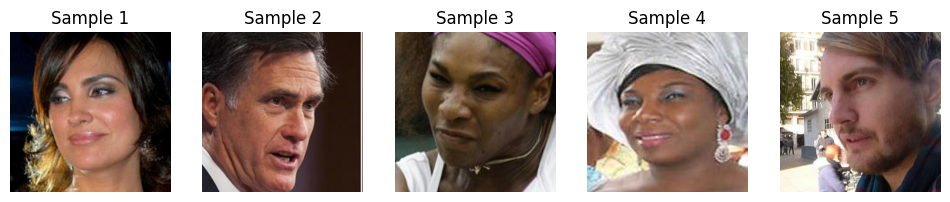

Total images found: 4186


In [4]:
# List and visualize a few sample images from the dataset
face_dir = 'face_dataset'
image_files = [f for f in os.listdir(face_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Show a few sample images
plt.figure(figsize=(12, 4))
for i, img_name in enumerate(image_files[:5]):
    img_path = os.path.join(face_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample {i+1}")
plt.show()

print(f"Total images found: {len(image_files)}")

## Preprocess Input Images

We will resize, normalize, and convert images to tensors as required by the model.

In [5]:
# Define preprocessing transforms (update normalization as per your model's training)
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def load_and_preprocess(img_path):
    img = Image.open(img_path).convert('RGB')
    return preprocess(img).unsqueeze(0)  # Add batch dimension

## Run Inference on Face Images

We will pass preprocessed images through the model to generate outputs. For demonstration, we will use a few images from the dataset.

In [8]:
# Run inference on a few images using FaceEncoder for embeddings
from model import FaceEncoder

# Instantiate and load encoder
encoder = FaceEncoder(embedding_dim=512, freeze_backbone=True)
encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder.eval()

outputs = []
input_imgs = []

for img_name in image_files[:5]:
    img_path = os.path.join(face_dir, img_name)
    input_tensor = load_and_preprocess(img_path)
    # Get embedding from encoder
    with torch.no_grad():
        embedding = encoder(input_tensor)
        # Generate noise vector
        noise = torch.randn(input_tensor.shape[0], 100)
        # Generate image from generator
        output = model(embedding, noise)
    outputs.append(output.squeeze(0))
    input_imgs.append(Image.open(img_path).convert('RGB'))

print('Inference completed on sample images.')

Inference completed on sample images.


## Display and Interpret Inference Results

We will visualize the generated images alongside the original input images for qualitative evaluation.

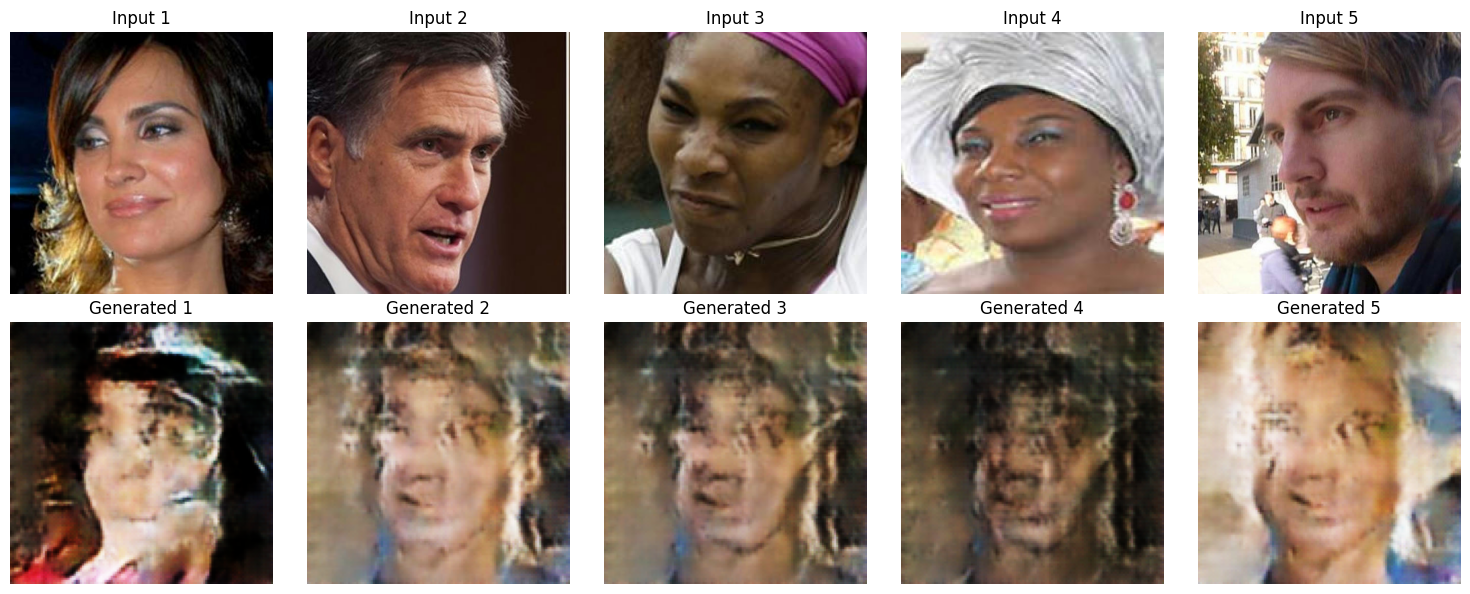

In [9]:
# Visualize input and generated images side by side
def tensor_to_image(tensor):
    tensor = tensor.detach().cpu()
    tensor = tensor * 0.5 + 0.5  # Unnormalize
    np_img = tensor.numpy().transpose(1, 2, 0)
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)

plt.figure(figsize=(15, 6))
for i, (inp, out) in enumerate(zip(input_imgs, outputs)):
    plt.subplot(2, 5, i+1)
    plt.imshow(inp)
    plt.axis('off')
    plt.title(f"Input {i+1}")
    plt.subplot(2, 5, i+6)
    plt.imshow(tensor_to_image(out))
    plt.axis('off')
    plt.title(f"Generated {i+1}")
plt.tight_layout()
plt.show()

## (Optional) Face Verification Using the Model

We can demonstrate face verification by comparing model outputs (embeddings or generated images) for pairs of images to determine if they belong to the same person.

In [10]:
# Example: Compare outputs for pairs of images using cosine similarity
from torch.nn.functional import cosine_similarity

if len(outputs) >= 2:
    sim = cosine_similarity(outputs[0].flatten(), outputs[1].flatten(), dim=0)
    print(f"Cosine similarity between generated outputs of first two images: {sim.item():.4f}")
else:
    print("Not enough outputs to compare.")

Cosine similarity between generated outputs of first two images: 0.5745


## Evaluation Metrics and wandb Dashboard

Below, we compute a simple MSE (reconstruction loss) between generated and real images for the shown samples. For more advanced evaluation, consider using FID or other perceptual metrics.


- [wandb Dashboard Link](https://wandb.ai/kunalchhabraiitb-alloan-ai/face-generation-verification/runs/dgjwmtrh?nw=nwuserkunalchhabraiitb)

In [11]:
# Compute MSE (reconstruction loss) between generated and real images
import torch.nn.functional as F

mse_scores = []
for i, (inp, out) in enumerate(zip(input_imgs, outputs)):
    # Preprocess real image to tensor (same as generator output)
    real_tensor = preprocess(inp).squeeze(0)
    gen_tensor = out
    mse = F.mse_loss(gen_tensor, real_tensor).item()
    mse_scores.append(mse)
    print(f"Sample {i+1}: MSE = {mse:.4f}")

print(f"Average MSE over {len(mse_scores)} samples: {np.mean(mse_scores):.4f}")

Sample 1: MSE = 0.2482
Sample 2: MSE = 0.3250
Sample 3: MSE = 0.3283
Sample 4: MSE = 0.8010
Sample 5: MSE = 0.4480
Average MSE over 5 samples: 0.4301


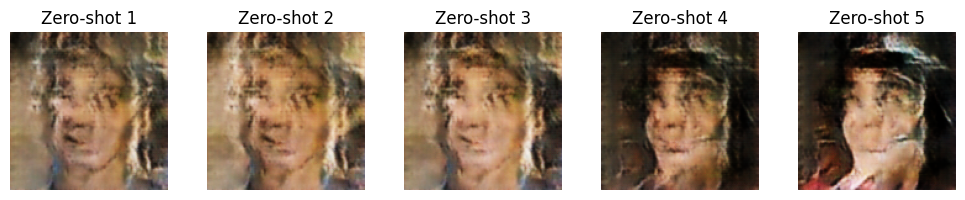

In [12]:
# Zero-shot generation: Generate images from random embeddings and noise
random_outputs = []
num_samples = 5

for _ in range(num_samples):
    # Generate random embedding (normalized)
    random_embedding = torch.randn(1, 512)
    random_embedding = F.normalize(random_embedding, p=2, dim=1)
    # Generate random noise
    noise = torch.randn(1, 100)
    with torch.no_grad():
        random_img = model(random_embedding, noise)
    random_outputs.append(random_img.squeeze(0))

# Visualize zero-shot generated images
plt.figure(figsize=(10, 2))
for i, img in enumerate(random_outputs):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(tensor_to_image(img))
    plt.axis('off')
    plt.title(f"Zero-shot {i+1}")
plt.tight_layout()
plt.show()

## Advanced Metrics and Production-Readiness

To ensure high-quality, production-ready generative models, we use advanced metrics:
- **Fréchet Inception Distance (FID):** Measures similarity between real and generated image distributions (lower is better).
- **Embedding Consistency Score:** Measures how well generated images match their conditioning embeddings (higher is better).
- **Diversity Score:** Measures how diverse the generated images are (higher is better).

These metrics help us understand model quality, generalization, and robustness. Automated tests and clear metric reporting are essential for production ML workflows.

In [14]:
# Compute FID, embedding consistency, and diversity using GANMetrics
!pip install scikit-learn
from metrics import GANMetrics

# Get real and generated features (embeddings) using encoder
real_features = []
fake_features = []
for inp, out in zip(input_imgs, outputs):
    real_tensor = preprocess(inp).unsqueeze(0)
    with torch.no_grad():
        real_emb = encoder(real_tensor)
        fake_emb = encoder(out.unsqueeze(0))
    real_features.append(real_emb.squeeze(0).numpy())
    fake_features.append(fake_emb.squeeze(0).numpy())
real_features = np.stack(real_features)
fake_features = np.stack(fake_features)

# FID
fid_score = GANMetrics.frechet_inception_distance(real_features, fake_features)
print(f"FID (lower is better): {fid_score:.4f}")

# Embedding Consistency
consistency_mean, consistency_std = GANMetrics.embedding_consistency_score(real_features, fake_features)
print(f"Embedding Consistency (higher is better): {consistency_mean:.4f} ± {consistency_std:.4f}")

# Diversity
diversity = GANMetrics.diversity_score(fake_features)
print(f"Diversity Score (higher is better): {diversity['diversity_score']:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 11.6 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
FID (lower is better): 0.9370
Embedding Consistency (higher is better): 0.5210 ± 0.0266
Diversity Score (higher is better): 0.3205


In [15]:
# Simple test: Check generator output shape for random embedding and noise
random_embedding = torch.randn(1, 512)
random_embedding = torch.nn.functional.normalize(random_embedding, p=2, dim=1)
noise = torch.randn(1, 100)
with torch.no_grad():
    test_output = model(random_embedding, noise)
print(f"Generator output shape: {test_output.shape}")
assert test_output.shape == (1, 3, 128, 128), "Generator output shape is incorrect!"

Generator output shape: torch.Size([1, 3, 128, 128])
